In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from utils import load_data, get_daily_data, get_forecast_dates

ModuleNotFoundError: No module named 'utils'

In [2]:
def load_data():
    confirmed_df = pd.read_csv("covid19_confirmed_global.txt")
    deaths_df = pd.read_csv("covid19_deaths_global.txt")

    # only filter US data
    cols = confirmed_df.keys()
    confirmed = confirmed_df[confirmed_df["Country/Region"] == "US"].loc[:, cols[4]:cols[-1]]
    deaths = deaths_df[deaths_df["Country/Region"] == "US"].loc[:, cols[4]:cols[-1]]

    # get the dates
    dates = confirmed.keys()

    return confirmed, deaths, dates

def compute_daily_statistic(data):
    daily_df = data.T.diff(periods=1)
    daily_df.columns = ["cnt"]
    daily_df.iloc[0, 0] = confirmed.iloc[0, 0]
    daily_df = daily_df.reset_index(drop=False)
    daily_df.columns = ["date", "cnt"]
    return daily_df

- preprocess data

In [3]:
confirmed, deaths, dates = load_data()
confirmed_daily = compute_daily_statistic(confirmed)
death_daily = compute_daily_statistic(deaths)

In [4]:
test_data_size = 100

train_data = confirmed_daily["cnt"].iloc[:-test_data_size]
test_data = confirmed_daily["cnt"].iloc[-test_data_size:]

In [5]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [6]:
seq_length = 7
X_train, y_train = create_sequences(train_data.to_numpy().reshape(-1,1), seq_length)
X_test, y_test = create_sequences(test_data.to_numpy().reshape(-1,1), seq_length)

In [7]:
X_train.shape

(570, 7, 1)

In [8]:
X_test.shape

(92, 7, 1)

- build model

In [9]:
from tensorflow.keras import backend
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import initializers

In [10]:
model = keras.Sequential(
    [
        BatchNormalization(),
        LSTM(128, activation= 'relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = False),
        Dropout(0.5),
        Dense(32, activation = 'relu', kernel_initializer = 'random_uniform'),
        Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1, activation = 'relu')
    ]
) 

optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=optimizer)

In [11]:
model_save_name = "lstm_model_confirm"

history = model.fit(x=X_train, y=y_train,
                    epochs=15, batch_size=8, verbose=2,
                    callbacks = [EarlyStopping(monitor='loss', patience=5, verbose=2, mode='min')])

model.save('Q2_output/%s.h5' % model_save_name)

Epoch 1/15
72/72 - 1s - loss: 3327615744.0000
Epoch 2/15
72/72 - 0s - loss: 5861017088.0000
Epoch 3/15
72/72 - 0s - loss: 3420547328.0000
Epoch 4/15
72/72 - 0s - loss: 2895143168.0000
Epoch 5/15
72/72 - 0s - loss: 1563153792.0000
Epoch 6/15
72/72 - 0s - loss: 1770271744.0000
Epoch 7/15
72/72 - 0s - loss: 2389520640.0000
Epoch 8/15
72/72 - 0s - loss: 1965380480.0000
Epoch 9/15
72/72 - 0s - loss: 1354041216.0000
Epoch 10/15
72/72 - 0s - loss: 2185696768.0000
Epoch 11/15
72/72 - 0s - loss: 1864841856.0000
Epoch 12/15
72/72 - 0s - loss: 1401609600.0000
Epoch 13/15
72/72 - 0s - loss: 2072595584.0000
Epoch 14/15
72/72 - 0s - loss: 2389502976.0000
Epoch 00014: early stopping


In [12]:
model = keras.models.load_model("Q2_output/lstm_model.h5")

In [13]:
y_test_pred = model.predict(X_test)

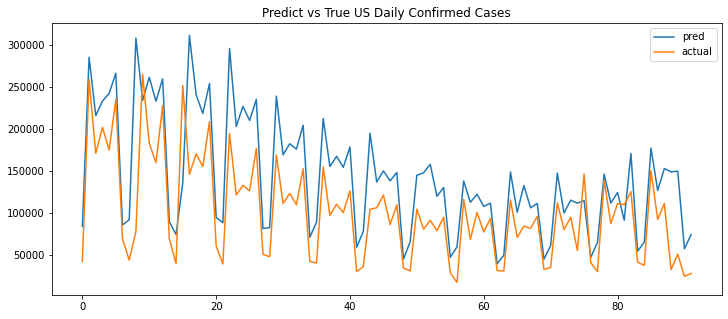

In [14]:
fig = plt.figure(figsize=(12,5))
plt.plot(y_test_pred, label="pred")
plt.plot(y_test, label = "actual")
plt.legend()
plt.title("Predict vs True US Daily Confirmed Cases")
plt.show()

- predict next 7 days

ModuleNotFoundError: No module named 'utils'

In [18]:
preds = []
test_seq = X_test[-1].reshape((1, 7, 1))

for i in range(8):
    y_test_pred = model(test_seq)
    pred = y_test_pred.numpy()[0][0]
    preds.append(pred)
    new_seq = test_seq.flatten()
    new_seq = np.append(new_seq, [pred])
    test_seq = new_seq[1:].reshape((1,7,1))

In [19]:
preds

[74376.17,
 189289.14,
 126794.05,
 132556.97,
 47308.18,
 62686.777,
 51810.43,
 124279.64]